# Real Estate Time Series

data sourced from [Zillow Research](https://www.zillow.com/research/data/) Under "LIST AND SALE PRICES" filtered by Median Sale Price (Raw, All Homes, Monthly).

![Zillow Data Pic](./img/zillow_data.png)

# Exploratory Data Analysis

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_percentage_error
import itertools

import warnings
warnings.filterwarnings('ignore')

In [12]:
df_raw = pd.read_csv('./data/zillow_sale.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Columns: 188 entries, RegionID to 2023-04-30
dtypes: float64(183), int64(2), object(3)
memory usage: 924.0+ KB


In [13]:
df_raw.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
0,102001,0,United States,country,NaN,180000.0,185000.0,185000.0,187000.0,193000.0,...,353000.0,346000.0,340000.0,335000.0,327000.0,322000.0,319000.0,329999.0,340000.0,349900.0
1,394913,1,"New York, NY",msa,NY,404586.0,399000.0,400000.0,400000.0,405000.0,...,579900.0,575000.0,550000.0,531500.0,525000.0,515000.0,520000.0,515000.0,515000.0,535000.0
2,753899,2,"Los Angeles, CA",msa,CA,503000.0,495750.0,500000.0,490000.0,482500.0,...,875000.0,867750.0,850000.0,845000.0,830000.0,810000.0,815000.0,825000.0,842750.0,850000.0
3,394463,3,"Chicago, IL",msa,IL,239000.0,237500.0,241000.0,240000.0,250000.0,...,310000.0,300000.0,285000.0,280000.0,279000.0,275000.0,270000.0,270000.0,289000.0,305000.0
4,394514,4,"Dallas, TX",msa,TX,137000.0,144000.0,143900.0,145874.0,154750.0,...,410000.0,400000.0,387900.0,385000.0,374705.0,364000.0,350000.0,373000.0,375000.0,385000.0


# Step 2: Data Preprocessing

In [14]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'StateName', 'RegionType'], var_name='Date', value_name='Median-Price')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True).dt.to_period('M')
    melted = melted.dropna(subset=['Median-Price'])
    return melted

In [15]:
df = melt_data(df_raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89656 entries, 0 to 115106
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   RegionName    89656 non-null  object   
 1   RegionID      89656 non-null  int64    
 2   SizeRank      89656 non-null  int64    
 3   StateName     89473 non-null  object   
 4   RegionType    89656 non-null  object   
 5   Date          89656 non-null  period[M]
 6   Median-Price  89656 non-null  float64  
dtypes: float64(1), int64(2), object(3), period[M](1)
memory usage: 5.5+ MB


In [16]:
df.head()

,RegionName,RegionID,SizeRank,StateName,RegionType,Date,Median-Price
0,United States,102001,0,NaN,country,2008-02,180000.0
1,"New York, NY",394913,1,NY,msa,2008-02,404586.0
2,"Los Angeles, CA",753899,2,CA,msa,2008-02,503000.0
3,"Chicago, IL",394463,3,IL,msa,2008-02,239000.0
4,"Dallas, TX",394514,4,TX,msa,2008-02,137000.0


In [17]:
df['StateName'].value_counts()

StateName
CA    5427
NC    5315
FL    4538
OH    4403
TX    4092
MI    3944
PA    3904
GA    3832
TN    3449
WI    3448
IL    3278
NY    2974
IN    2857
OR    2588
CO    2321
MO    2194
SC    2124
AL    2118
MN    1874
KY    1761
VA    1746
AZ    1691
AR    1605
WA    1600
OK    1594
UT    1139
NV    1137
LA    1098
MA     915
CT     915
MD     904
IA     818
NH     732
NJ     732
MT     732
HI     720
ID     695
ME     694
NM     647
WY     440
NE     368
MS     366
DE     366
KS     353
WV     353
SD     306
ND     183
RI     183
Name: count, dtype: int64

In [18]:
df = df[df['RegionName'].isin(df['RegionName'].value_counts()[df['RegionName'].value_counts() >= 183].index)]
df = df[df['StateName'] == 'CA']
df.drop(columns=['RegionID', 'StateName', 'RegionType'], inplace=True)
usa_med = df[df['RegionName'] == 'United States']
df = df[df['RegionName'] != 'United States']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4941 entries, 2 to 114904
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   RegionName    4941 non-null   object   
 1   SizeRank      4941 non-null   int64    
 2   Date          4941 non-null   period[M]
 3   Median-Price  4941 non-null   float64  
dtypes: float64(1), int64(1), object(1), period[M](1)
memory usage: 193.0+ KB


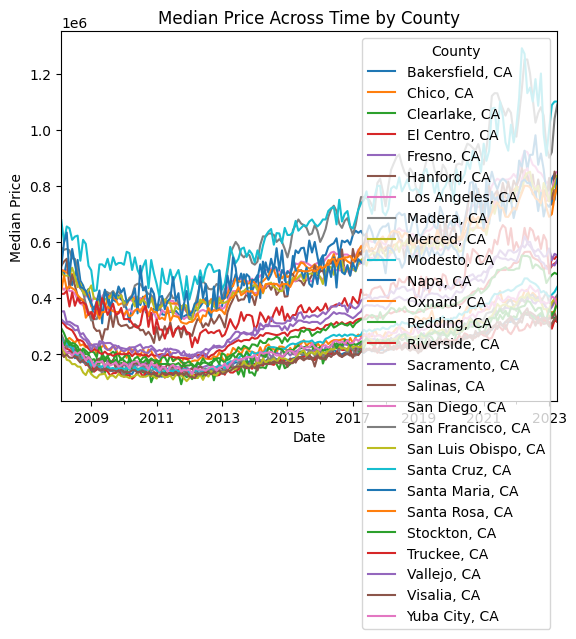

In [20]:

grouped_median_prices = df.groupby(['RegionName', 'Date'])['Median-Price'].median().unstack(level=0)

grouped_median_prices.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Median Price')
plt.title('Median Price Across Time by County')
plt.legend(title='County')
plt.show()

## Checking for stationarity

The ADF Statistic is negative and the p-value is less than the significance level (0.05). This indicates that the median sale price data is stationary. So we can proceed to creating ARIMA model without applying transformations or differencing to the data.

In [25]:
result = adfuller(df['Median-Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.824619
p-value: 0.998397


In [28]:
# Grouping DataFrame by 'RegionName'
grouped = df.groupby('RegionName')

# For each group (RegionName) apply ADF test
for region, group in grouped:
    
    # Performing Augmented Dickey Fuller test
    result = adfuller(group['Median-Price'])

    # Print Region Name, Test Statistics and p-value
    print(f"Region Name: {region}")
    print(f"Test Statistics: {result[0]}")
    print(f"p-value: {result[1]}")
    
    # Determine if the data is stationary
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")
    
    print("\n")

Region Name: Bakersfield, CA
Test Statistics: -0.7874711329046001
p-value: 0.8227746531085995
Data is not stationary


Region Name: Chico, CA
Test Statistics: 0.1328268382622906
p-value: 0.9682321754560119
Data is not stationary


Region Name: Clearlake, CA
Test Statistics: -0.05072796007257633
p-value: 0.954130398239214
Data is not stationary


Region Name: El Centro, CA
Test Statistics: 0.11799931920405371
p-value: 0.9672687214782053
Data is not stationary


Region Name: Fresno, CA
Test Statistics: 0.4468928455746003
p-value: 0.9831663610806609
Data is not stationary


Region Name: Hanford, CA
Test Statistics: 1.2156478389477314
p-value: 0.9960922317439208
Data is not stationary


Region Name: Los Angeles, CA
Test Statistics: -0.8819538381989088
p-value: 0.7938571748206027
Data is not stationary


Region Name: Madera, CA
Test Statistics: 0.3951934547092133
p-value: 0.9813143018247018
Data is not stationary


Region Name: Merced, CA
Test Statistics: 0.6584213791862997
p-value: 0.98897

## Differencing the data to make it stationary

In [29]:
# Initialize an empty DataFrame to hold differenced data
diff_df = pd.DataFrame()

# For each group (RegionName), calculate difference and add to diff_df
for region, group in grouped:
    group = group.set_index('Date')
    group['Median-Price'] = group['Median-Price'].diff()
    group = group.reset_index()
    group['RegionName'] = region
    diff_df = pd.concat([diff_df, group], ignore_index=True)

# Drop the first row of each group (has NaN values because of differencing)
diff_df = diff_df.dropna(subset=['Median-Price'])

In [30]:
diff_df.head()

,Date,RegionName,SizeRank,Median-Price
1,2008-03,"Bakersfield, CA",63,5000.0
2,2008-04,"Bakersfield, CA",63,-20000.0
3,2008-05,"Bakersfield, CA",63,10000.0
4,2008-06,"Bakersfield, CA",63,1000.0
5,2008-07,"Bakersfield, CA",63,-25000.0


## Plotting ACF and PACF of differenced time series

In [33]:
diff_df['RegionName'].value_counts()

RegionName
Bakersfield, CA        182
Sacramento, CA         182
Visalia, CA            182
Vallejo, CA            182
Truckee, CA            182
Stockton, CA           182
Santa Rosa, CA         182
Santa Maria, CA        182
Santa Cruz, CA         182
San Luis Obispo, CA    182
San Francisco, CA      182
San Diego, CA          182
Salinas, CA            182
Riverside, CA          182
Chico, CA              182
Redding, CA            182
Oxnard, CA             182
Napa, CA               182
Modesto, CA            182
Merced, CA             182
Madera, CA             182
Los Angeles, CA        182
Hanford, CA            182
Fresno, CA             182
El Centro, CA          182
Clearlake, CA          182
Yuba City, CA          182
Name: count, dtype: int64

Region: Bakersfield, CA


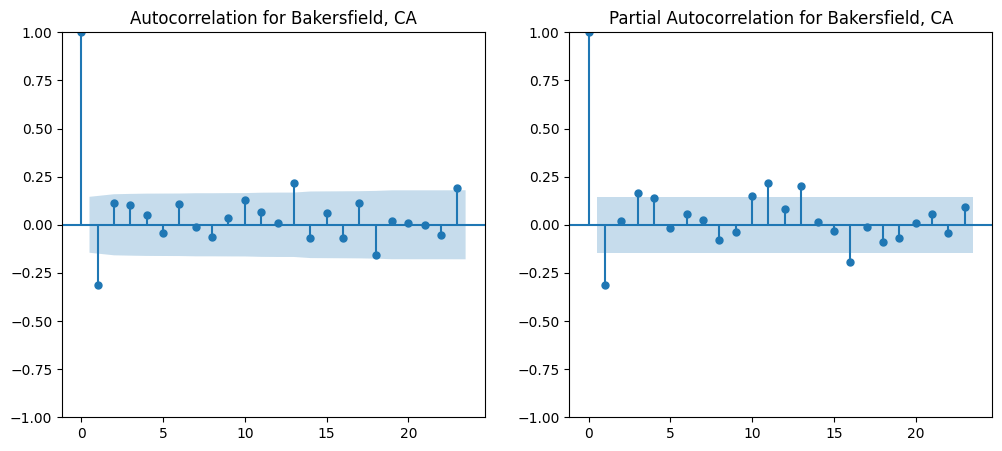

Region: Chico, CA


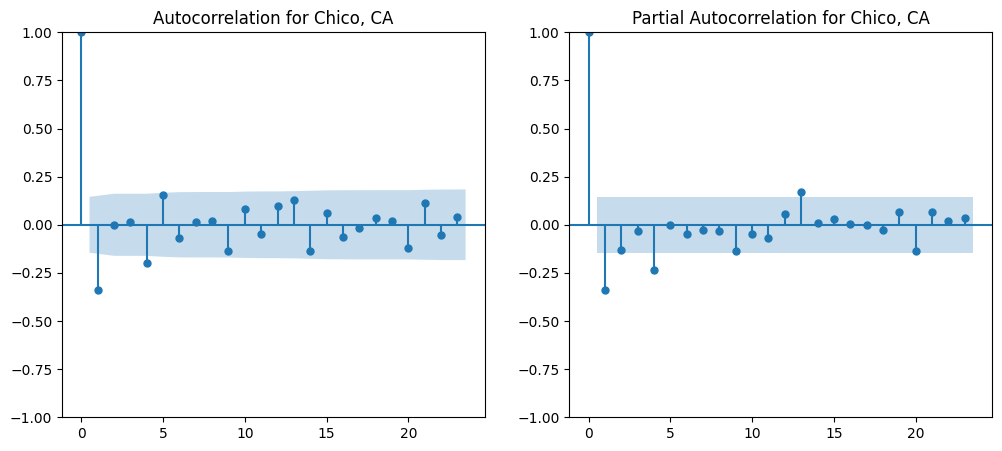

Region: Clearlake, CA


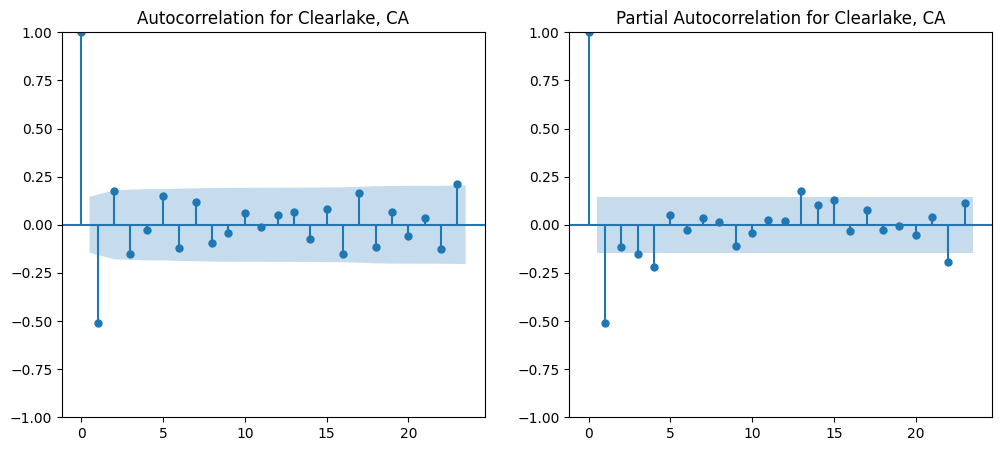

Region: El Centro, CA


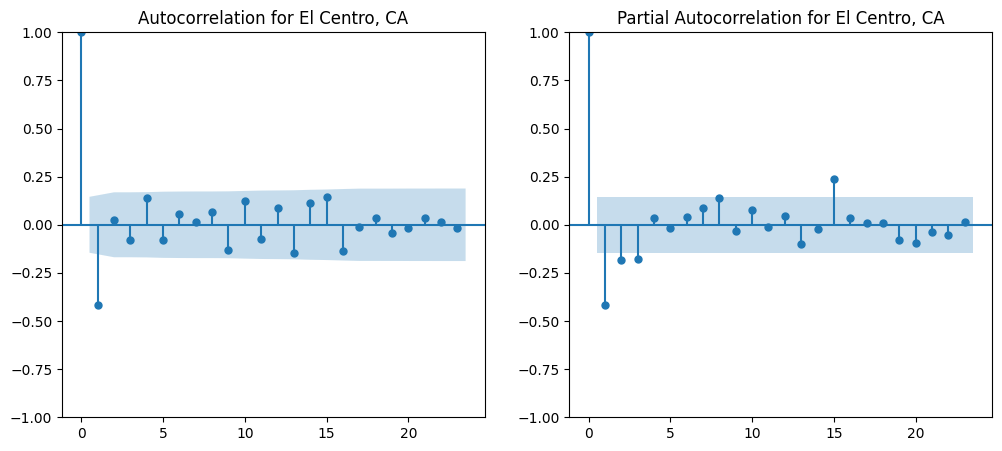

Region: Fresno, CA


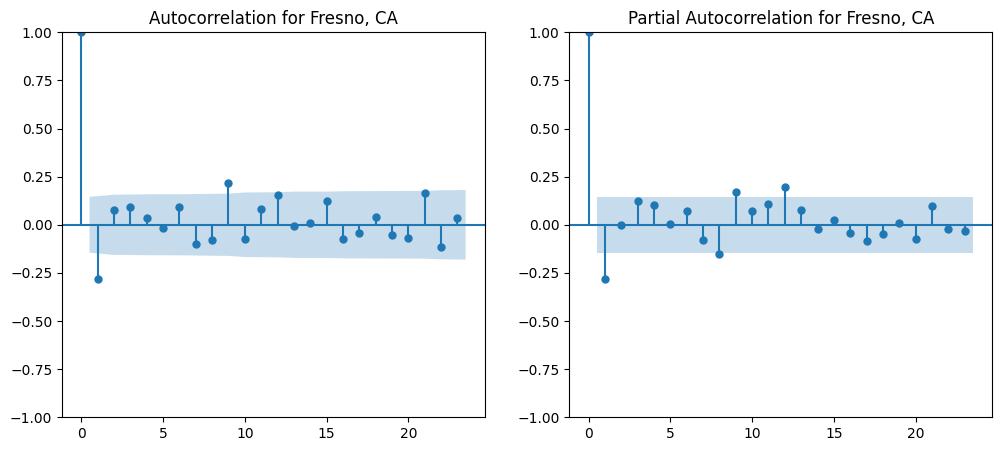

Region: Hanford, CA


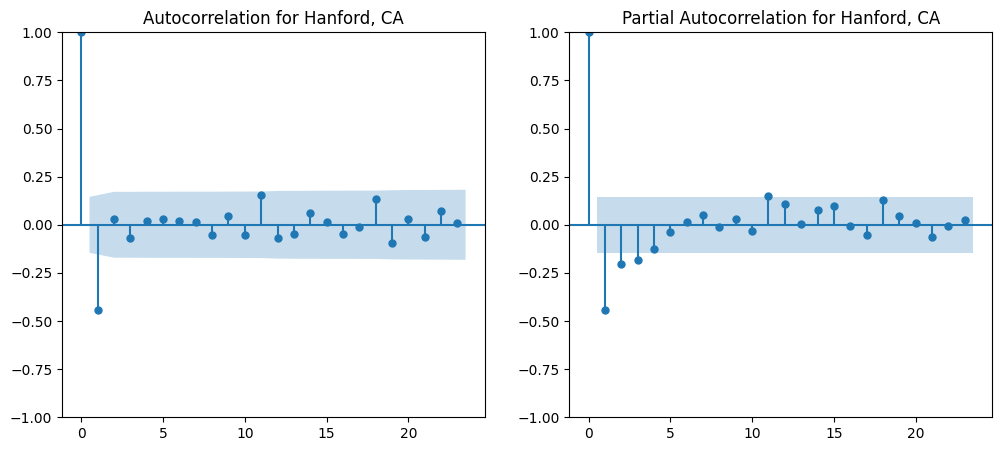

Region: Los Angeles, CA


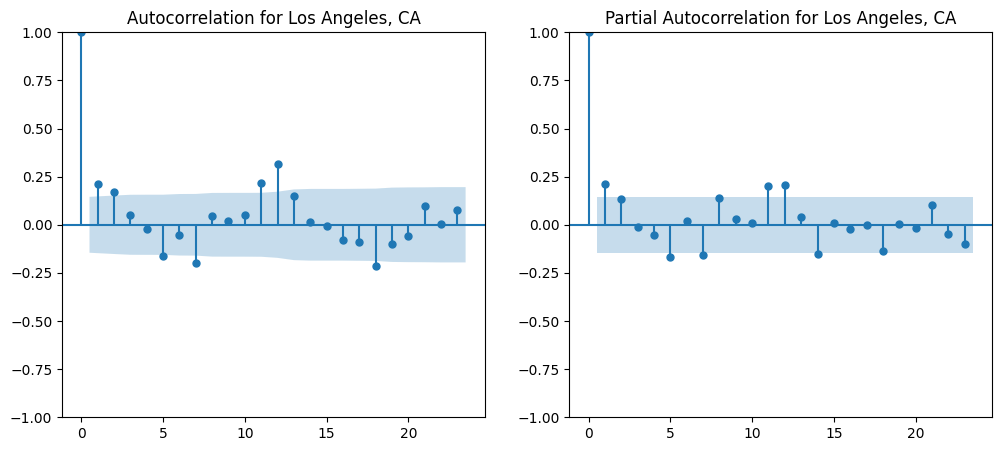

Region: Madera, CA


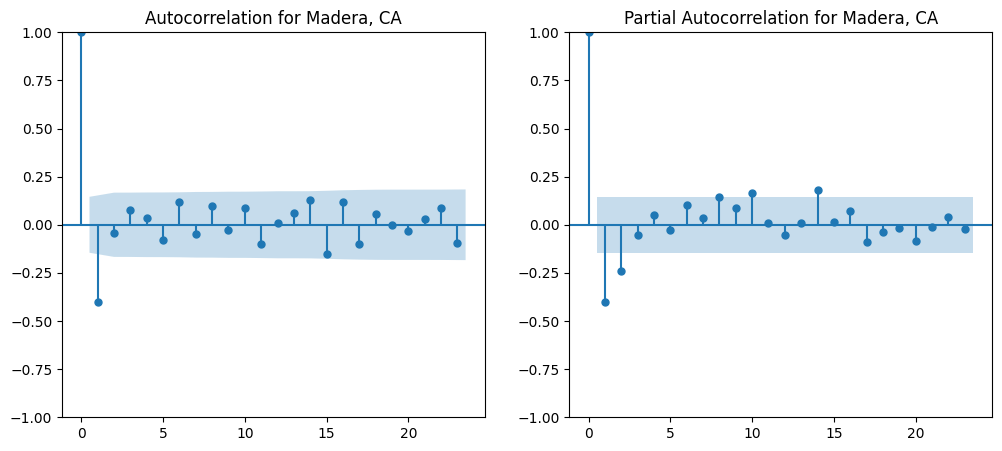

Region: Merced, CA


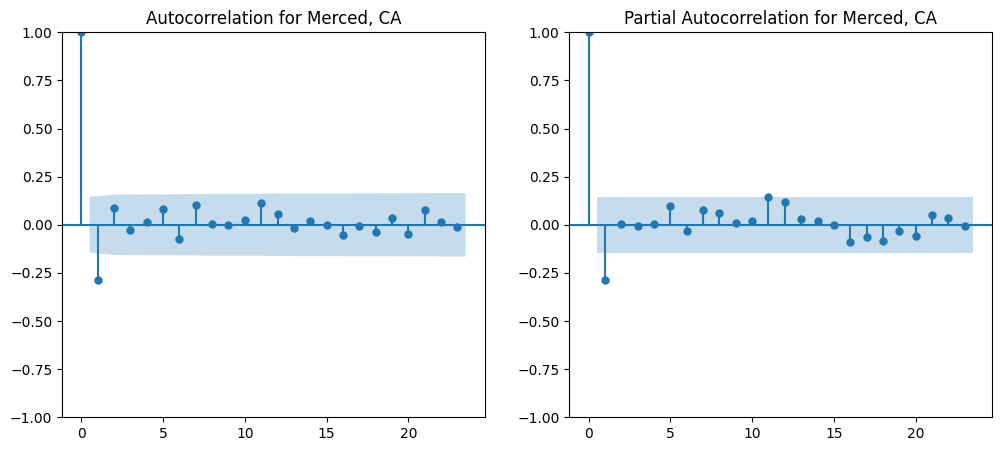

Region: Modesto, CA


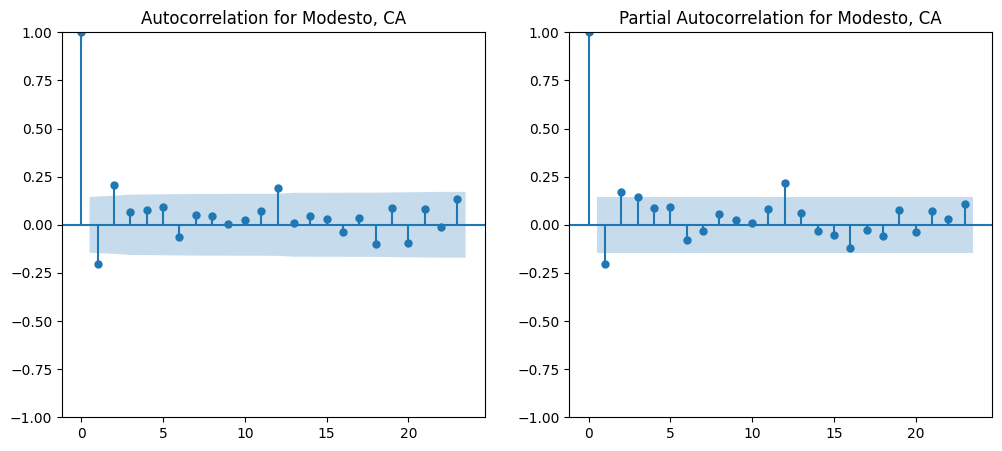

Region: Napa, CA


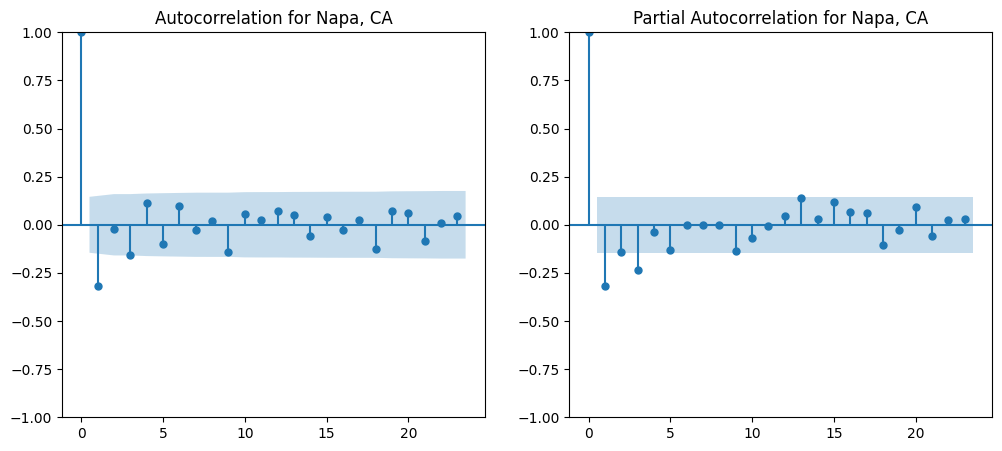

Region: Oxnard, CA


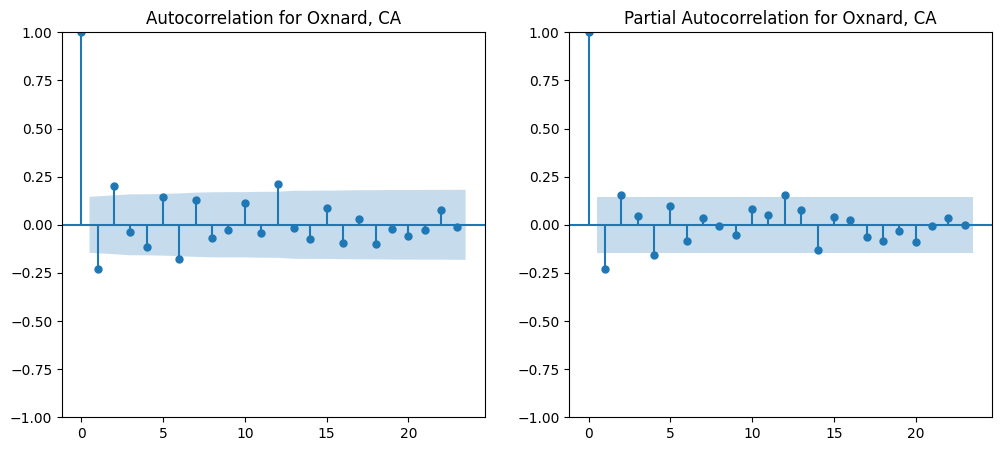

Region: Redding, CA


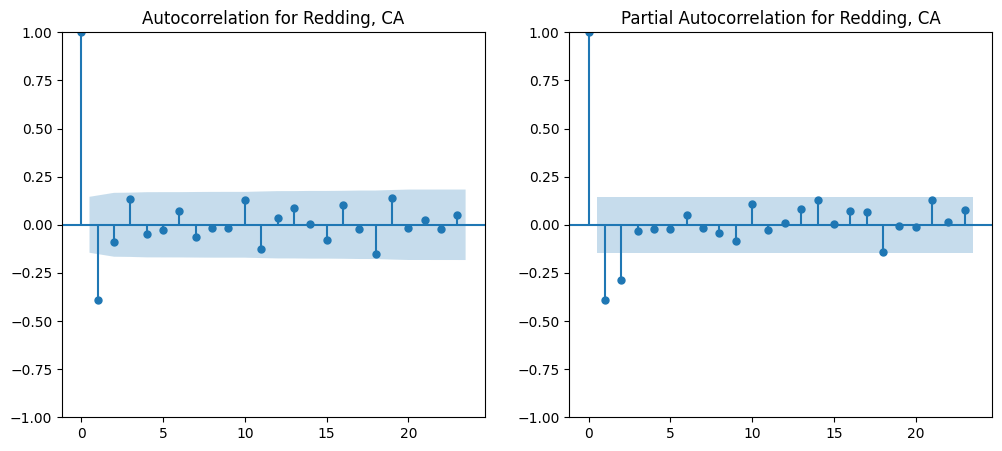

Region: Riverside, CA


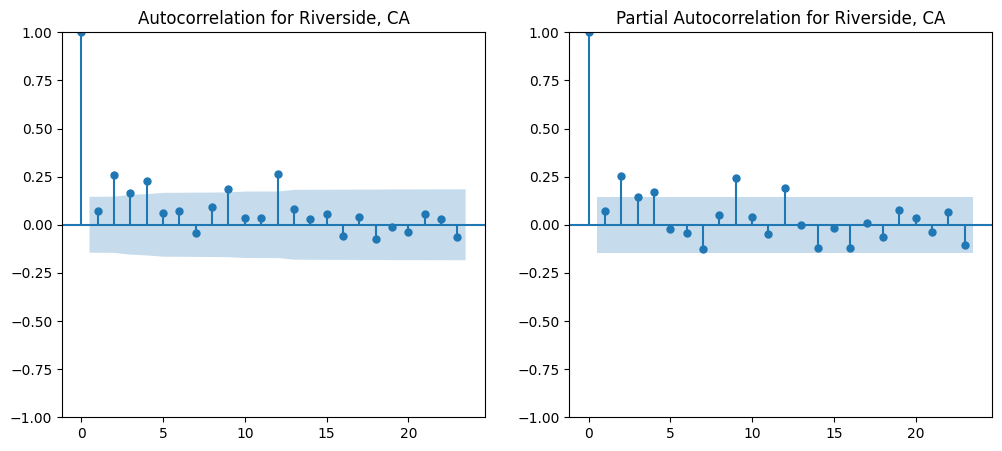

Region: Sacramento, CA


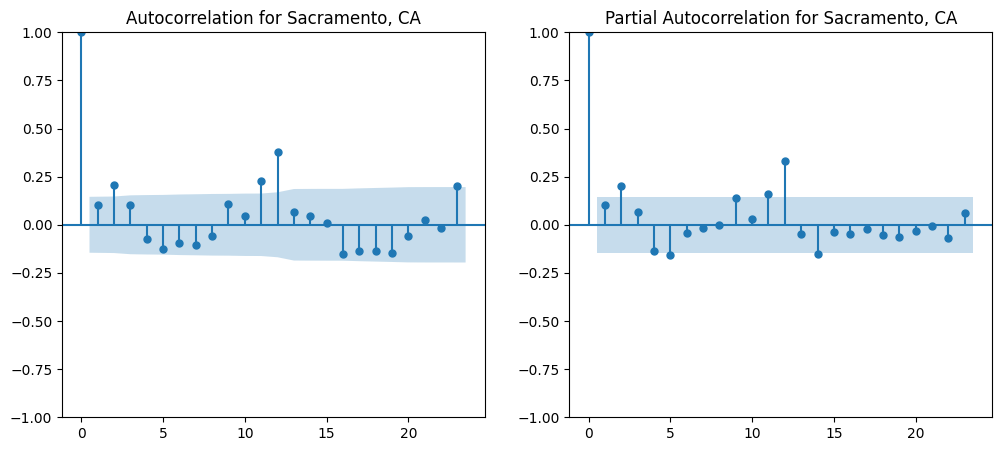

Region: Salinas, CA


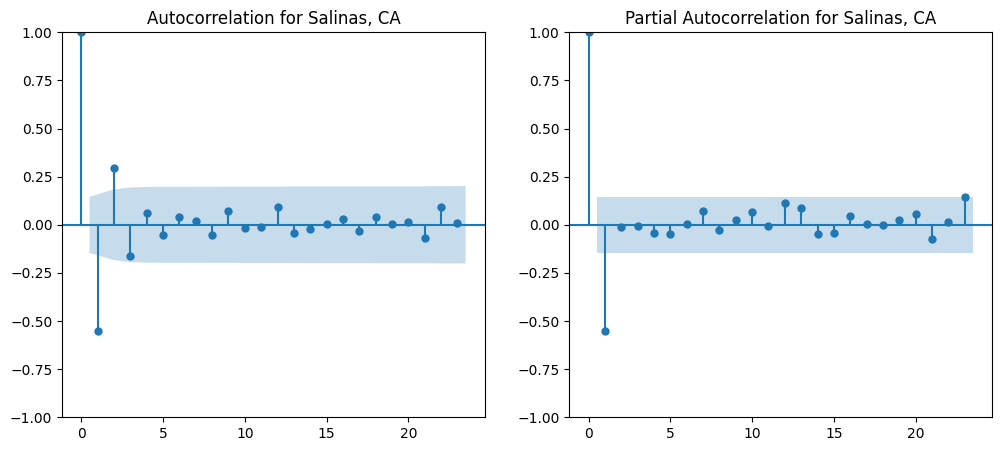

Region: San Diego, CA


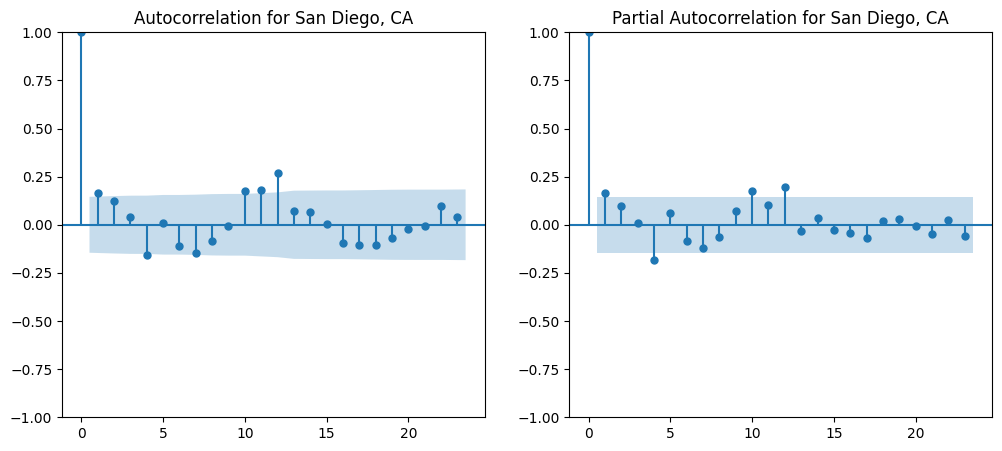

Region: San Francisco, CA


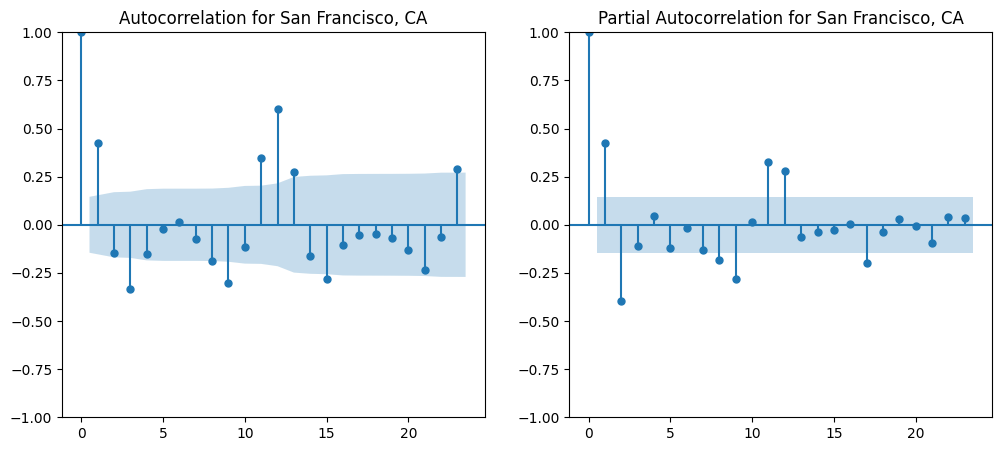

Region: San Luis Obispo, CA


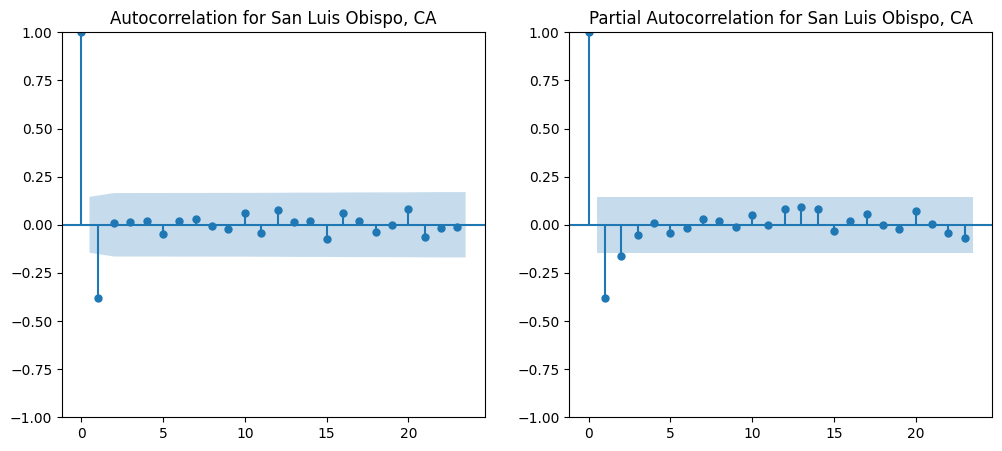

Region: Santa Cruz, CA


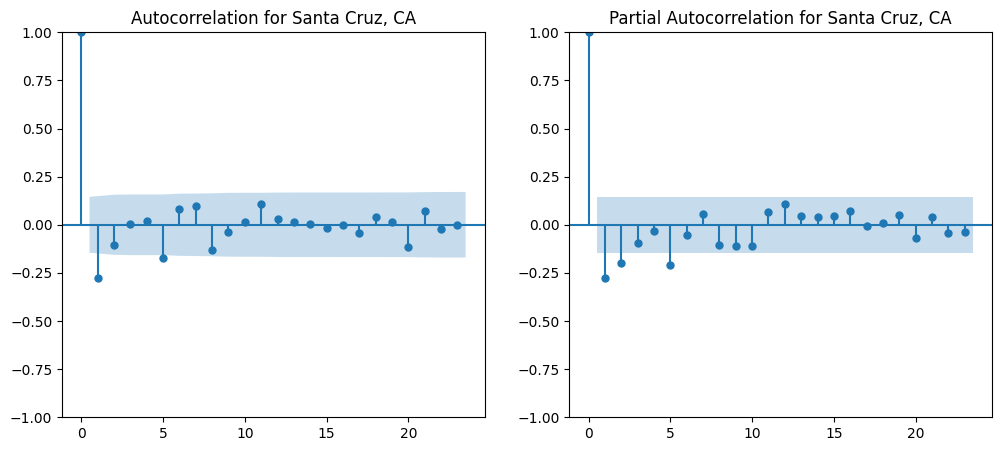

Region: Santa Maria, CA


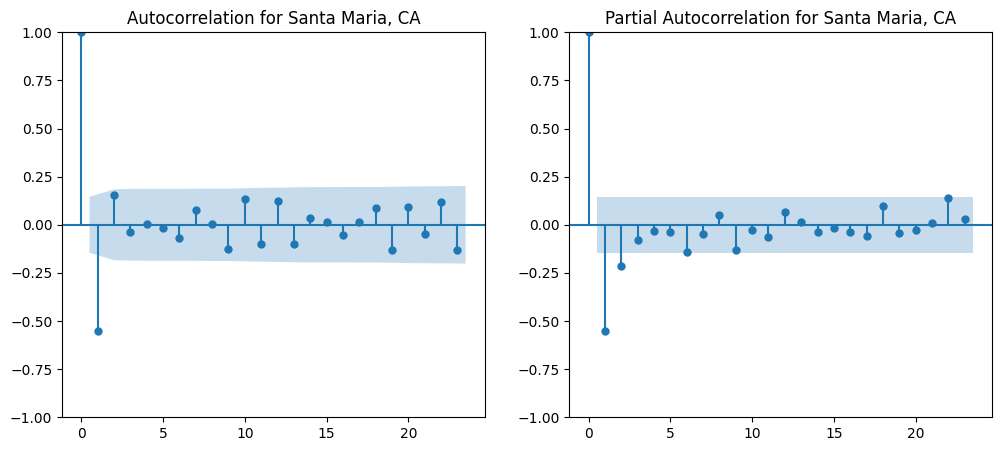

Region: Santa Rosa, CA


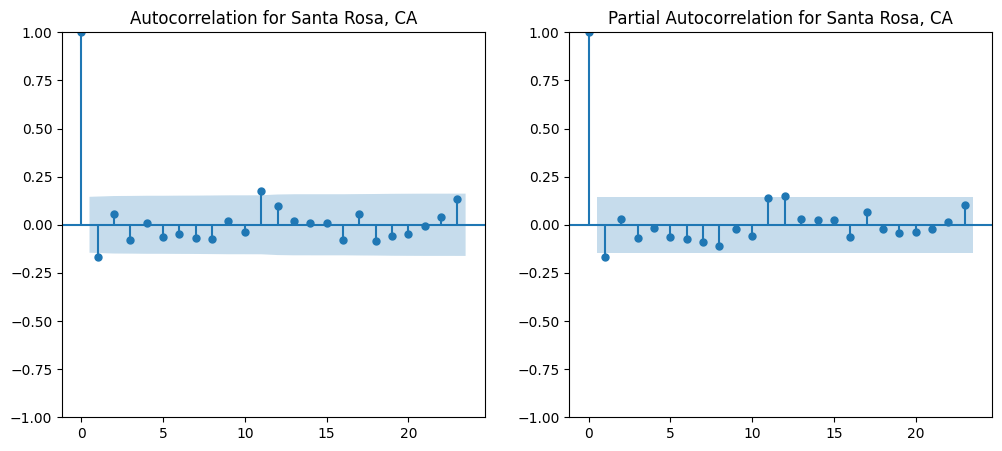

Region: Stockton, CA


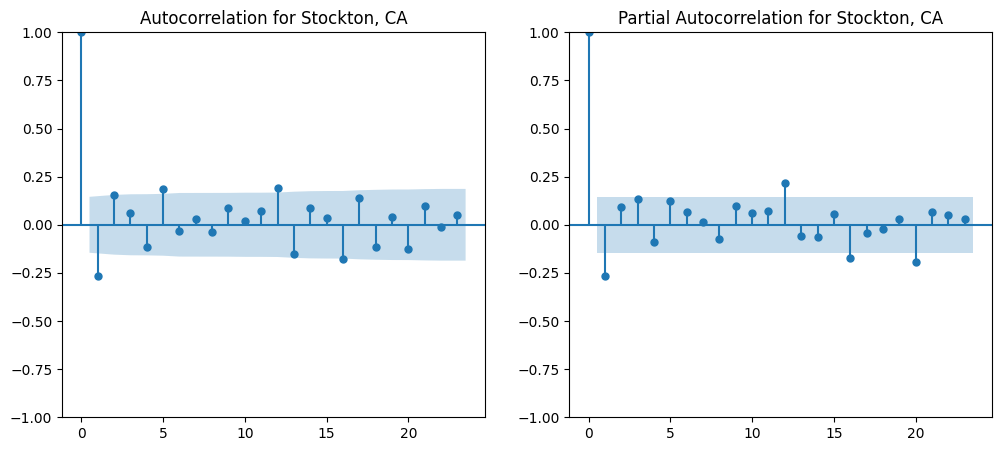

Region: Truckee, CA


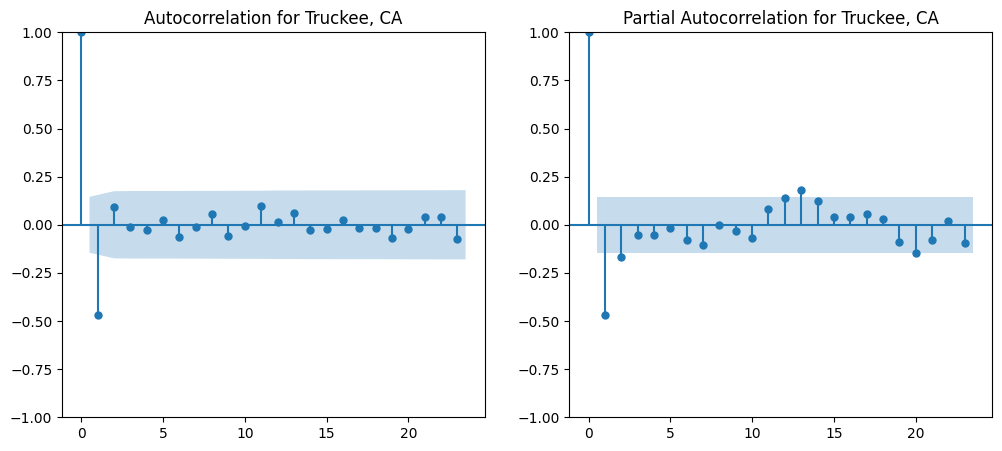

Region: Vallejo, CA


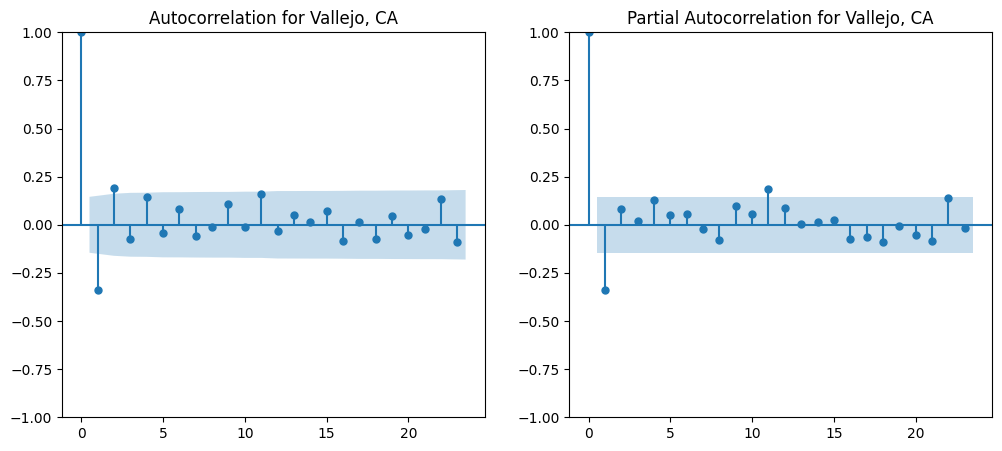

Region: Visalia, CA


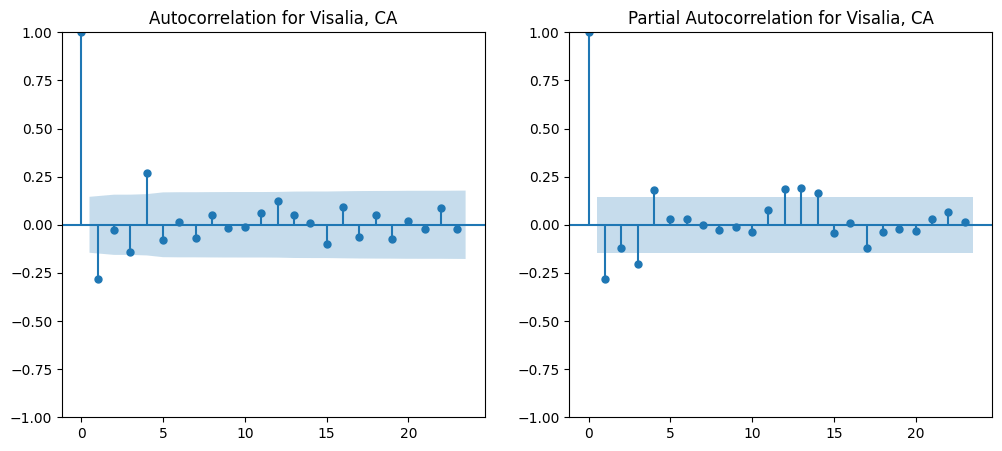

Region: Yuba City, CA


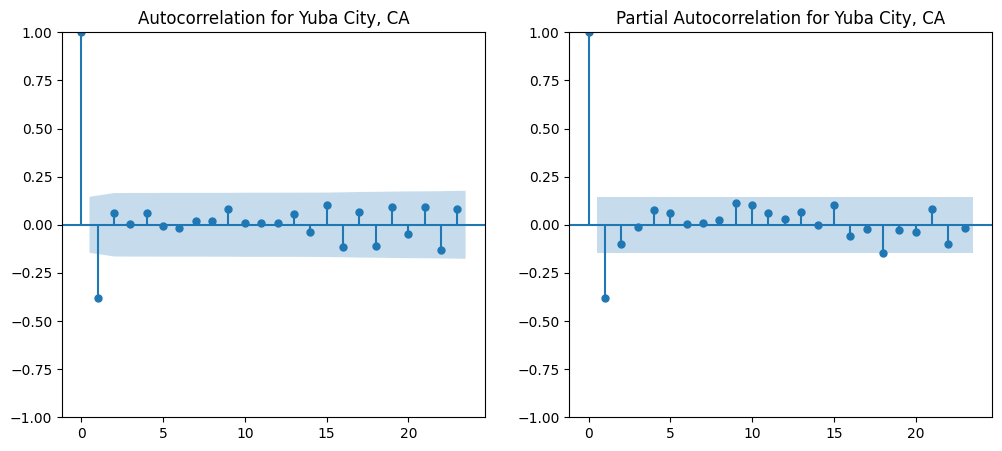

In [34]:
# Group new DataFrame by 'RegionName'
grouped_diff = diff_df.groupby('RegionName')

# For each group (each RegionName), plot ACF and PACF
for region, group in grouped_diff:
    print(f"Region: {region}")
    
    # Convert to series before plot
    median_price_series = group['Median-Price']

    # Plot ACF
    plt.figure(figsize=(12,5))
    plt.subplot(121) 
    plot_acf(median_price_series, ax=plt.gca(), title='Autocorrelation for '+ region )
    
    # Plot PACF
    plt.subplot(122)
    plot_pacf(median_price_series, ax=plt.gca(), title='Partial Autocorrelation for '+ region)
    
    plt.show()

## Arima Modeling

In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Get the list of all unique regions
all_regions = df['RegionName'].unique()

# Getting the last year in the dataset
last_year = df['Date'].max().year

# Creating an empty dataframe to store the ARIMA model results
arima_allregions_df = pd.DataFrame(columns=['RegionName', 'MedianPrice_Diff', 'ARIMA Model','AIC'])

# ARIMA modeling for all the regions
for region in all_regions:
    # Subset to the region
    df_region = df[df['RegionName'] == region]
    df_region.set_index('Date', inplace=True)

    # Calculate median price for the region for the last year
    median_price_last_year = df_region[df_region.index.year == last_year]['Median-Price'].median()
    
    # Fit ARIMA model
    model = ARIMA(df_region['Median-Price'], order=(1,0,1))
    model_fit = model.fit()
    
    # Make forecast for the next year
    prediction = model_fit.get_prediction(start=pd.to_datetime(str(last_year+1)+'-01'), dynamic=False)
    predicted_median_price = prediction.predicted_mean[0]
    
    # Calculate the difference in median price from the most current year to the predicted median price
    median_price_diff = predicted_median_price - median_price_last_year
    
    # Append results to dataframe
    arima_allregions_df.loc[len(arima_allregions_df.index)] = [region, median_price_diff, model_fit, model_fit.aic]

# Sorting by the difference in median prices
arima_allregions_df = arima_allregions_df.sort_values('MedianPrice_Diff', ascending=False)
print(arima_allregions_df)

             RegionName  MedianPrice_Diff   
10       Santa Rosa, CA      52908.596714  \
1     San Francisco, CA      50014.409691   
3         San Diego, CA      27306.940215   
18            Chico, CA      19938.994377   
9           Modesto, CA      17484.923029   
15  San Luis Obispo, CA      16563.556544   
4        Sacramento, CA      12947.507922   
0       Los Angeles, CA       9880.399751   
2         Riverside, CA       8548.229865   
7            Oxnard, CA       8355.630932   
22           Madera, CA       6940.904838   
11          Visalia, CA       5918.210495   
13      Santa Maria, CA       5687.061332   
5            Fresno, CA       4499.115924   
19          Redding, CA       4257.981385   
26        Clearlake, CA       1221.168221   
8          Stockton, CA      -2959.261982   
23          Hanford, CA      -3637.903969   
16           Merced, CA      -4996.595635   
20        El Centro, CA      -5151.345735   
6       Bakersfield, CA      -5956.833609   
25        

In [42]:
# Get the list of all unique regions
all_regions = df['RegionName'].unique()

# Getting the last year in the dataset
last_year = df['Date'].max().year

# Creating an empty dataframe to store the ARIMA model results
arima_allregions_df = pd.DataFrame(columns=['RegionName', 'MedianPrice_Diff', 'ARIMA Model','AIC'])

# ARIMA modeling for all the regions
for region in all_regions:
    # Subset to the region
    df_region = df[df['RegionName'] == region]
    df_region.set_index('Date', inplace=True)

    # Calculate median price for the region for the last year
    median_price_last_year = df_region[df_region.index.year == last_year]['Median-Price'].median()
    
    # Fit ARIMA model
    model = ARIMA(df_region['Median-Price'], order=(2,0,2))
    model_fit = model.fit()
    
    # Make forecast for the next year
    prediction = model_fit.get_prediction(start=pd.to_datetime(str(last_year+1)+'-01'), dynamic=False)
    predicted_median_price = prediction.predicted_mean[0]
    
    # Calculate the difference in median price from the most current year to the predicted median price
    median_price_diff = predicted_median_price - median_price_last_year
    
    # Append results to dataframe
    arima_allregions_df.loc[len(arima_allregions_df.index)] = [region, median_price_diff, model_fit, model_fit.aic]

# Sorting by the difference in median prices
arima_allregions_df = arima_allregions_df.sort_values('MedianPrice_Diff', ascending=False)
print(arima_allregions_df)

             RegionName  MedianPrice_Diff   
1     San Francisco, CA      60125.034353  \
10       Santa Rosa, CA      56768.796907   
2         Riverside, CA      26995.226727   
3         San Diego, CA      26466.423233   
18            Chico, CA      20277.198938   
15  San Luis Obispo, CA      16999.492893   
4        Sacramento, CA      15849.049838   
7            Oxnard, CA      13158.128443   
0       Los Angeles, CA       9925.360226   
22           Madera, CA       8587.265300   
13      Santa Maria, CA       6560.926262   
9           Modesto, CA       4333.991742   
11          Visalia, CA       4298.875451   
19          Redding, CA       4073.284638   
26        Clearlake, CA       1206.532535   
5            Fresno, CA       -203.591494   
20        El Centro, CA       -999.785617   
8          Stockton, CA      -2561.322200   
23          Hanford, CA      -3427.935362   
12          Vallejo, CA      -4929.357013   
16           Merced, CA      -4947.467855   
24        

In [43]:
from statsmodels.tsa.arima.model import ARIMA

# Get the list of all unique regions
all_regions = df['RegionName'].unique()

# Getting the last year in the dataset
last_year = df['Date'].max().year

# Creating an empty dataframe to store the ARIMA model results
arima_allregions_df = pd.DataFrame(columns=['RegionName', 'MedianPrice_Diff', 'ARIMA Model','AIC'])

# ARIMA modeling for all the regions
for region in all_regions:
    # Subset to the region
    df_region = df[df['RegionName'] == region]
    df_region.set_index('Date', inplace=True)

    # Calculate median price for the region for the last year
    median_price_last_year = df_region[df_region.index.year == last_year]['Median-Price'].median()
    
    # Fit ARIMA model
    model = ARIMA(df_region['Median-Price'], order=(1,0,1))
    model_fit = model.fit()
    
    # Make forecast for the next year
    prediction = model_fit.get_prediction(start=pd.to_datetime(str(last_year+1)+'-01'), dynamic=False)
    predicted_median_price = prediction.predicted_mean[0]
    
    # Calculate the difference in median price from the most current year to the predicted median price
    median_price_diff = predicted_median_price - median_price_last_year
    
    # Append results to dataframe
    arima_allregions_df.loc[len(arima_allregions_df.index)] = [region, median_price_diff, model_fit, model_fit.bic]

# Sorting by the difference in median prices
arima_allregions_df = arima_allregions_df.sort_values('MedianPrice_Diff', ascending=False)
print(arima_allregions_df)

             RegionName  MedianPrice_Diff   
10       Santa Rosa, CA      52908.596714  \
1     San Francisco, CA      50014.409691   
3         San Diego, CA      27306.940215   
18            Chico, CA      19938.994377   
9           Modesto, CA      17484.923029   
15  San Luis Obispo, CA      16563.556544   
4        Sacramento, CA      12947.507922   
0       Los Angeles, CA       9880.399751   
2         Riverside, CA       8548.229865   
7            Oxnard, CA       8355.630932   
22           Madera, CA       6940.904838   
11          Visalia, CA       5918.210495   
13      Santa Maria, CA       5687.061332   
5            Fresno, CA       4499.115924   
19          Redding, CA       4257.981385   
26        Clearlake, CA       1221.168221   
8          Stockton, CA      -2959.261982   
23          Hanford, CA      -3637.903969   
16           Merced, CA      -4996.595635   
20        El Centro, CA      -5151.345735   
6       Bakersfield, CA      -5956.833609   
25        

## Mean Absolute Percentage Error (MAPE):
Measures the average percentage difference between predicted and actual values.
Useful for comparing forecast accuracy across different time series.
Lower values indicate better model performance.

In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#mape = mean_absolute_percentage_error(actual_values, predicted_values)

## Return On Investment Yield (ROI Yield)